In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ohbemn import wave, Solver, Region, source

wave length: [39.01922213]
elements: 128


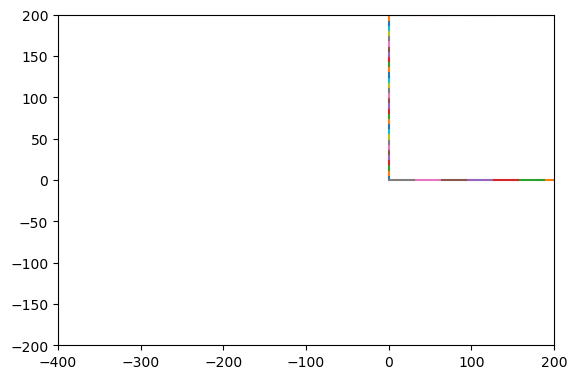

In [35]:
T = 5.   # [s]
f = 1/T
d = 40.  # [m]
c, cg, k = wave.wavec_interm(T, d)
print("wave length:", c/f)

region = Region.rectangle(1000, 200, 32, 32)

f, ax = plt.subplots()
region.plot(ax)
ax.set_xlim([-400, 200])
ax.set_ylim([-200, 200])
ax.set_aspect('equal')

print("elements:", region.len())

The breakwater is completely solid. So the boundary condition along its boundary is:

$\frac{\partial \phi}{\partial n} = 0$

which, since it is defined on the derivative of the velocity potential is a Neumann boundary condition.

In [36]:
bc = region.neumann_boundary_condition()
bc.f.fill(0)

The incoming field is a plane wave. Calculate $\phi$ and $\frac{\partial \phi}{\partial n}$ at the center of each boundary element.

In [38]:
bi = region.boundary_incidence()

centers = region.centers()
normals = region.normals()

for i in range(region.len()):
    x = centers[i, :]
    n = normals[i, :]

    phi = source.plane(0, k, *x)[0]
    dphidn = source.dplane(0, k, x[0], x[1], n)[0]

    bi.v[i] = dphidn
    #bi.phi[i] = phi

    print("Center:", x, "Normal:", n, "dPhidn: ", dphidn)


Center: [0.    3.125] Normal: [-1.  0.] dPhidn:  0j
Center: [0.    9.375] Normal: [-1.  0.] dPhidn:  0j
Center: [ 0.    15.625] Normal: [-1.  0.] dPhidn:  0j
Center: [ 0.    21.875] Normal: [-1.  0.] dPhidn:  0j
Center: [ 0.    28.125] Normal: [-1.  0.] dPhidn:  0j
Center: [ 0.    34.375] Normal: [-1.  0.] dPhidn:  0j
Center: [ 0.    40.625] Normal: [-1.  0.] dPhidn:  0j
Center: [ 0.    46.875] Normal: [-1.  0.] dPhidn:  0j
Center: [ 0.    53.125] Normal: [-1.  0.] dPhidn:  0j
Center: [ 0.    59.375] Normal: [-1.  0.] dPhidn:  0j
Center: [ 0.    65.625] Normal: [-1.  0.] dPhidn:  0j
Center: [ 0.    71.875] Normal: [-1.  0.] dPhidn:  0j
Center: [ 0.    78.125] Normal: [-1.  0.] dPhidn:  0j
Center: [ 0.    84.375] Normal: [-1.  0.] dPhidn:  0j
Center: [ 0.    90.625] Normal: [-1.  0.] dPhidn:  0j
Center: [ 0.    96.875] Normal: [-1.  0.] dPhidn:  0j
Center: [  0.    103.125] Normal: [-1.  0.] dPhidn:  0j
Center: [  0.    109.375] Normal: [-1.  0.] dPhidn:  0j
Center: [  0.    115.625] No

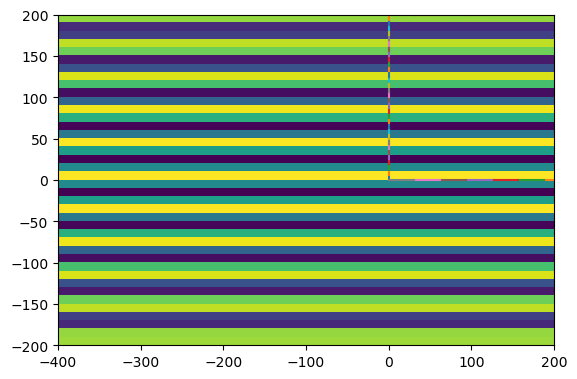

In [39]:
# Sample grid

x = np.arange(-400, 200, 10)
y = np.arange(-200, 200, 10)
xx, yy = np.meshgrid(x, y)

# Incident field without break-water
fI = source.plane(0, k, xx, yy)

f, ax = plt.subplots()
ax.set_aspect('equal')
region.plot(ax)
ax.imshow(fI.real, origin='lower', extent=[-400, 200, -200, 200])

In [40]:
# Solve boundary.

solver = Solver(region)
boundary_solution = solver.solve_boundary('exterior', k, c, bc, bi)
print(boundary_solution)

c:      [7.80384443] m/s
index   Potential               eta

1 (0.09737669676542282-0.08109541237354279j) [-0.01039167-0.01247798j]
2 (-0.12221752852201462+0.0448131188750267j) [0.00574241+0.01566112j]
3 (-0.2330044060945511+0.10427602380514145j) [0.01336207+0.02985749j]
4 (-0.1315639615058899+0.07007364928722382j) [0.00897933+0.01685878j]
5 (0.08074701577425003-0.014487681910395622j) [-0.00185647-0.01034703j]
6 (0.20622017979621887-0.06496470421552658j) [-0.00832466-0.02642533j]
7 (0.13577163219451904-0.034660711884498596j) [-0.00444147-0.01739796j]
8 (-0.055674437433481216+0.04238058999180794j) [0.0054307+0.0071342j]
9 (-0.18726037442684174+0.08553194999694824j) [0.01096018+0.02399579j]
10 (-0.1437242478132248+0.04639646038413048j) [0.0059453+0.01841701j]
11 (0.022857267409563065-0.0426047146320343j) [-0.00545942-0.00292896j]
12 (0.15204325318336487-0.09677162766456604j) [-0.01240044-0.01948302j]
13 (0.1312667429447174-0.05922989174723625j) [-0.0075898-0.01682069j]
14 (-0.0025561060

In [41]:
# Solve samples
ep = np.vstack((xx.ravel(), yy.ravel())).T

print('Solving for exterior points:', ep.shape)
eF = boundary_solution.solve_samples(np.zeros(ep.shape[0]), ep)

Solving for exterior points: (2400, 2)


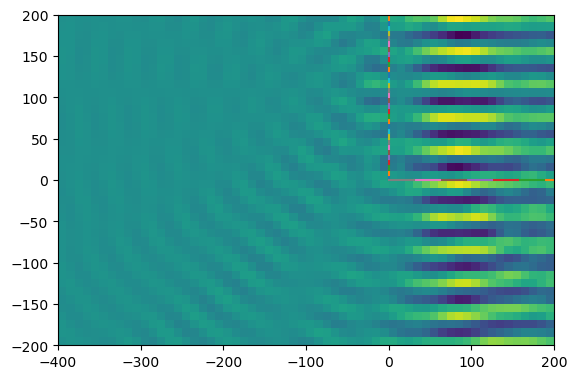

In [43]:
eFp = eF.phis.reshape(xx.shape)
f, ax = plt.subplots()
region.plot(ax)
ax.set_aspect('equal')
ax.imshow(eFp.real, origin='lower', extent=[-400, 200, -200, 200])